In [48]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [49]:
%matplotlib inline
import numpy as np
from IPython.core.debugger import Tracer
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pylab
import matplotlib
import matplotlib.pyplot as plt


In [56]:

class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(layers.Dense(256, input_shape=(100,)))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Dense(512))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Dense(1024))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(layers.Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(layers.Flatten(input_shape=self.shape))
        model.add(layers.Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        #self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 1000):

        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            # print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                print('The generating image in epoch: ', cnt)
                self.plot_images(save2file=True, step=cnt)


    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(3, 3))
        image = images[15, :, :, :]
        image = np.reshape(image, [self.height, self.width])
        plt.subplot(1, 1, 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.show()
        plt.close()



Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 784)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_114 (LeakyReLU)  (None, 392)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_______________________________________________

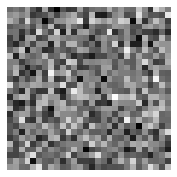

The generating image in epoch:  1000


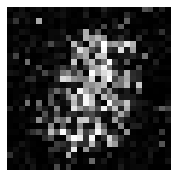

The generating image in epoch:  2000


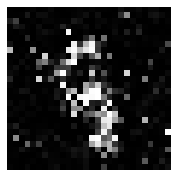

The generating image in epoch:  3000


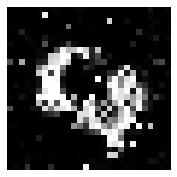

The generating image in epoch:  4000


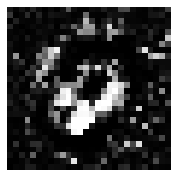

The generating image in epoch:  5000


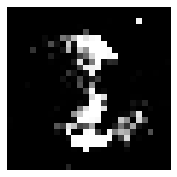

The generating image in epoch:  6000


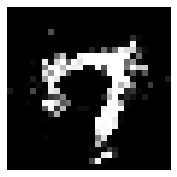

The generating image in epoch:  7000


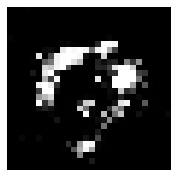

The generating image in epoch:  8000


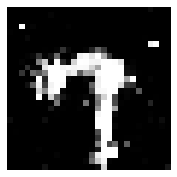

The generating image in epoch:  9000


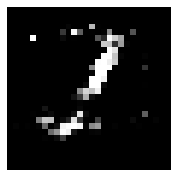

The generating image in epoch:  10000


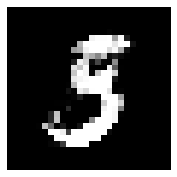

The generating image in epoch:  11000


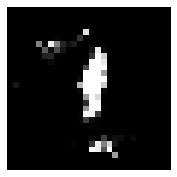

The generating image in epoch:  12000


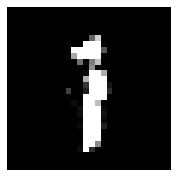

The generating image in epoch:  13000


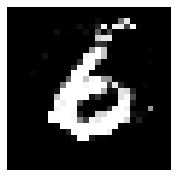

The generating image in epoch:  14000


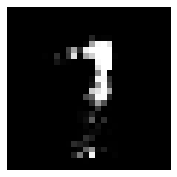

The generating image in epoch:  15000


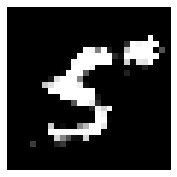

The generating image in epoch:  16000


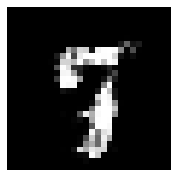

The generating image in epoch:  17000


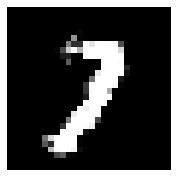

The generating image in epoch:  18000


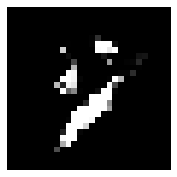

The generating image in epoch:  19000


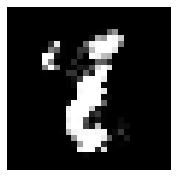

In [57]:
if __name__ == '__main__':
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)


    gan = GAN()
    gan.train(X_train)
